In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.3 MB/s eta 0:00:00


In [ ]:
!pip install torchvision torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vgg16
from torcheval.metrics import MulticlassAccuracy
from tqdm.notebook import trange, tqdm
from cleanvision.imagelab import Imagelab

Reading images from /content/drive/MyDrive/Animal Dataset 
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Issue checks completed. 923 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | odd_size         |          483 |
|  1 | near_duplicates  |          333 |
|  2 | exact_duplicates |           98 |
|  3 | odd_aspect_ratio |            6 |
|  4 | blurry           |            3 |
|  5 | dark             |            0 |
|  6 | light            |            0 |
|  7 | low_information  |            0 |
|  8 | grayscale        |            0 | 

--------------------- odd_size images ----------------------

Number of examples with this issue: 483
Examples representing most severe instances of this issue:



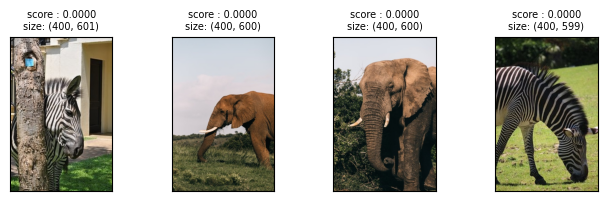

------------------ near_duplicates images ------------------

Number of examples with this issue: 333
Examples representing most severe instances of this issue:

Set: 0


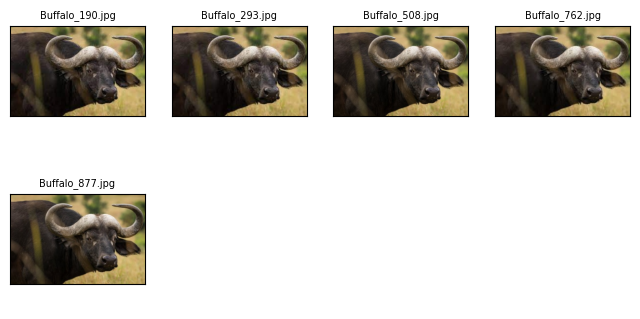

Set: 1


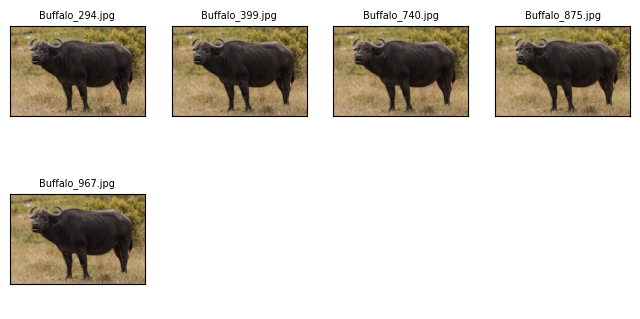

Set: 2


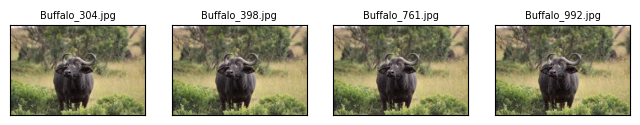

Set: 3


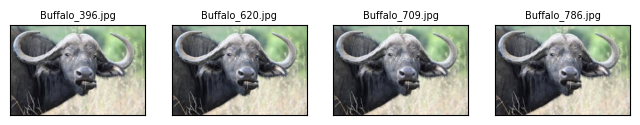

----------------- exact_duplicates images ------------------

Number of examples with this issue: 98
Examples representing most severe instances of this issue:

Set: 0


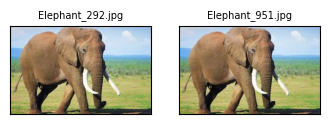

Set: 1


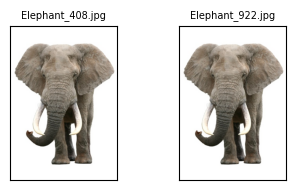

Set: 2


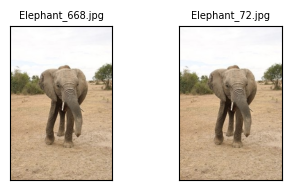

Set: 3


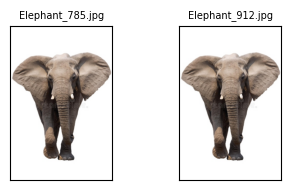

----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:



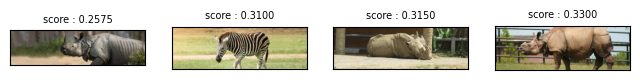

---------------------- blurry images -----------------------

Number of examples with this issue: 3
Examples representing most severe instances of this issue:



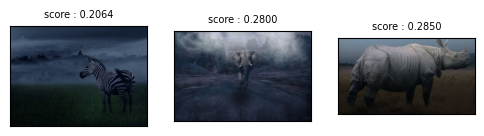

In [ ]:
imagelab = Imagelab(data_path="/content/drive/MyDrive/Animal Dataset ")
imagelab.find_issues()
imagelab.report()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
data_transform = transforms.Compose([transforms.Resize(size=(64, 64)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor() ])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [ ]:
img_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Animal Dataset ",transform=data_transform, target_transform=None)
img_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/drive/MyDrive/Animal Dataset 
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
generator = torch.Generator().manual_seed(42)
train_set, test_set, val_set = torch.utils.data.random_split(img_dataset, [0.7,0.2,0.1], generator=generator)
train_set, test_set, val_set

(<torch.utils.data.dataset.Subset at 0x7ec56ecb4610>,
 <torch.utils.data.dataset.Subset at 0x7ec56ecb7d60>)

In [ ]:
train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False)
val_dl = DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
transfer_model = vgg16(weights='IMAGENET1K_V1')

for param in transfer_model.features.parameters():
    param.requires_grad = False

transfer_model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,4))

opt1 = Adam(transfer_model.parameters())
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.0MB/s]


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),

            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

In [ ]:
 def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        print(x.shape, self.position_embeddings.shape)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

In [ ]:
class ViT_PyTorch(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, dim_feedforward=int(embed_dim*expansion), activation="gelu", batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=4096),
            nn.Linear(in_features=4096, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes)
        )

In [ ]:
def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

NUM_CLASSES = 4
PATCH_SIZE = 8
IMG_SIZE = 64
IN_CHANNELS = 3
NUM_HEADS = 12
DROPOUT = 0.001
NUM_ENCODERS = 6
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
EXPANSION = 32

original_model = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES)
opt2 = Adam(original_model.parameters())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
def train(model, optimizer, loss_fn, epoch, train_dl, test_dl, device=device):
    model.to(device)
    history = {"train_loss":[], "test_loss":[]}
    for e in range(epoch):
        model.train()

        running_loss = 0
        for i, (img, label) in tqdm(enumerate(train_dl)):
            optimizer.zero_grad()
            output = model(img.to(device))
            loss = loss_fn(output, label.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss/(i+1)
        history['train_loss'].append(avg_loss)

        model.eval()
        with torch.no_grad():
            running_loss = 0
            for i, (img, label) in enumerate(test_dl):
                output = model(img.to(device))

                loss = loss_fn(output,label.to(device))
                running_loss += loss.item()
            avg_loss = running_loss/(i+1)
            history['test_loss'].append(avg_loss)

    return history

In [ ]:
def validate_model(model):
    Accuracy = MulticlassAccuracy(average='macro', num_classes=4)
    model.eval()
    with torch.no_grad():
        running_loss = 0
        num_of_batches = 0
        for data, label in val_dl:
            output = model(data.to(device))
            loss = loss_fn(output, label.to(device))
            running_loss += loss.item()
            num_of_batches+=1

            pred = torch.argmax(output, dim=1)

            Accuracy.update(pred, label.to(device))
        test_loss = running_loss/num_of_batches
    return Accuracy, test_loss

In [ ]:
transfer_history = train(transfer_model,opt1,loss_fn, 10,train_dl,test_dl,device)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

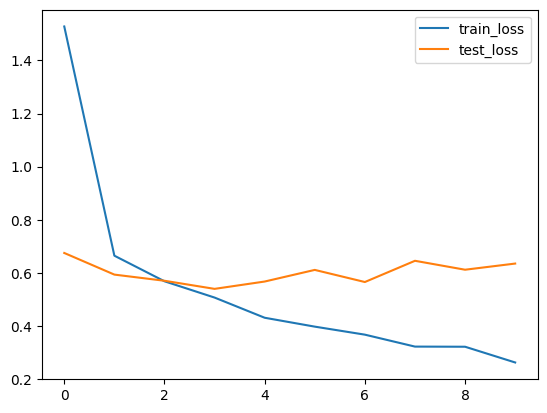

In [ ]:
plt.plot(transfer_history['train_loss'], label="train_loss")
plt.plot(transfer_history['test_loss'], label="test_loss")
plt.legend()
plt.show()

In [ ]:
Accuracy, test_loss = validate_model(transfer_model)

print(f'Loss:{test_loss}')
print(f'Accuracy:{Accuracy.compute()}')

/usr/local/lib/python3.10/dist-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


Loss:0.5644901181970324
Accuracy:0.7920595407485962


In [ ]:
class ViT_PyTorch(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, dim_feedforward=int(embed_dim*expansion), activation="gelu", batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=4096),
            nn.Linear(in_features=4096, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    # The forward method should be defined within the ViT_PyTorch class
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),

            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    # The forward method should be defined within the PatchEmbedding class
    def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        print(x.shape, self.position_embeddings.shape)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

In [ ]:
original_model = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES)
opt2 = Adam(original_model.parameters())

In [ ]:
original_history = train(original_model, opt1, loss_fn, 10, train_dl, test_dl, device)

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

0it [00:00, ?it/s]

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch

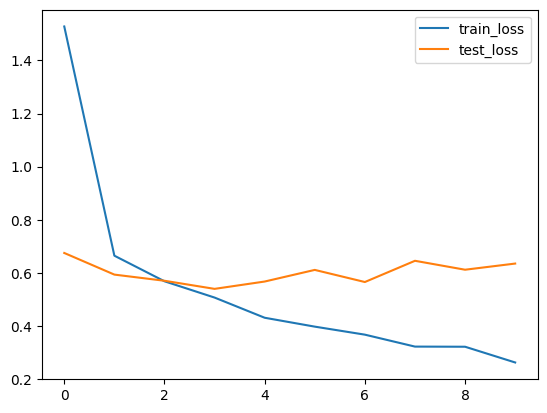

In [ ]:
plt.plot(transfer_history['train_loss'], label="train_loss")
plt.plot(transfer_history['test_loss'], label="test_loss")
plt.legend()
plt.show()

In [ ]:
Accuracy, test_loss = validate_model(original_model)

print(f'Loss:{test_loss}')
print(f'Accuracy:{Accuracy.compute()}')

torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([64, 65, 192]) torch.Size([1, 65, 192])
torch.Size([16, 65, 192]) torch.Size([1, 65, 192])
Loss:1.4094043629510062
Accuracy:0.25
